In [1]:
# Update environment (if needed)
# !sudo apt update

# Download and install Java
!sudo apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Install Apache Spark with Hadoop
!wget -nc -q https://downloads.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz

# Unzip the folder
!tar xf spark-3.5.3-bin-hadoop3.tgz

# Install findspark library that will locate Spark on the system
!pip install -q findspark

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 3.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [2]:
import os
import shutil
from itertools import islice
import requests
import matplotlib.pyplot as plt


os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"

In [3]:
# Locate Spark in the system

import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
# from pyspark.sql import functions as F
from pyspark.sql.types import *

# Create spark_session


# Initialize Spark Session with increased memory and configuration
spark = SparkSession.builder \
    .appName("Airline Delay Analysis") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.autoBroadcastJoinThreshold", "-1") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.driver.extraJavaOptions", "-XX:-UseGCOverheadLimit") \
    .getOrCreate()

sc = spark.sparkContext

spark.version

'3.5.3'

In [5]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import shutil
from itertools import islice
import requests
import pandas as pd

pd.set_option("max_colwidth", 100)

In [7]:
def get_gcs_data (bucket_name, folder_name, file_name, path_gdrive):
    url = 'https://storage.googleapis.com/' + bucket_name + '/' + folder_name + '/' + file_name
    r = requests.get(url)
    open(path_gdrive + '/' + file_name , 'wb').write(r.content)

In [ ]:
bucket_name = 'msca-bdp-data-open'
folder_name = 'airlines'
file_name = ['2007.csv','2008.csv']
path_gdrive = '/content/drive/My Drive/Colab Datasets/BDP/airlines'

os.makedirs(path_gdrive, exist_ok=True)

for file in file_name:
    get_gcs_data (bucket_name = bucket_name,
                 folder_name = folder_name,
                 file_name = file,
                 path_gdrive = path_gdrive)
    print('Downloaded: ' + file)

Downloaded: 2007.csv
Downloaded: 2008.csv


In [7]:
df_2007 = spark.read.option("header", "true").csv('/content/drive/My Drive/Colab Datasets/BDP/airlines/2007.csv')
df_2008 = spark.read.option("header", "true").csv('/content/drive/My Drive/Colab Datasets/BDP/airlines/2008.csv')

df_2007.cache()
df_2008.cache()

DataFrame[Year: string, Month: string, DayofMonth: string, DayOfWeek: string, DepTime: string, CRSDepTime: string, ArrTime: string, CRSArrTime: string, UniqueCarrier: string, FlightNum: string, TailNum: string, ActualElapsedTime: string, CRSElapsedTime: string, AirTime: string, ArrDelay: string, DepDelay: string, Origin: string, Dest: string, Distance: string, TaxiIn: string, TaxiOut: string, Cancelled: string, CancellationCode: string, Diverted: string, CarrierDelay: string, WeatherDelay: string, NASDelay: string, SecurityDelay: string, LateAircraftDelay: string]

In [9]:
df_2007.head()

Row(Year='2007', Month='1', DayofMonth='1', DayOfWeek='1', DepTime='1232', CRSDepTime='1225', ArrTime='1341', CRSArrTime='1340', UniqueCarrier='WN', FlightNum='2891', TailNum='N351', ActualElapsedTime='69', CRSElapsedTime='75', AirTime='54', ArrDelay='1', DepDelay='7', Origin='SMF', Dest='ONT', Distance='389', TaxiIn='4', TaxiOut='11', Cancelled='0', CancellationCode=None, Diverted='0', CarrierDelay='0', WeatherDelay='0', NASDelay='0', SecurityDelay='0', LateAircraftDelay='0')

In [10]:
df_2007.printSchema()

root
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- DayofMonth: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: string (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: string (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: string (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: string (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: string (nullable = true)
 |-- CarrierDelay:

In [8]:
df_2007 = df_2007.withColumn("ArrDelay", col("ArrDelay").cast("int")).withColumn("DepDelay", col("DepDelay").cast("int"))
df_2008 = df_2008.withColumn("ArrDelay", col("ArrDelay").cast("int")).withColumn("DepDelay", col("DepDelay").cast("int"))

df_2007.printSchema()

root
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- DayofMonth: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: string (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: string (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: string (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: string (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: string (nullable = true)
 |-- CarrierDela

In [14]:
df_2007.show()

+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|2007|    1|         1|        1|   1232|      1225|   1341|      1340|           WN|     2891

#1. Which locations (Origin and Dest pairs) had the worst delays for both arrivals (ArrDelay) and departures (DepDelay) - for each year

Location pair ONT-IAD had the highest average arrival delay in 2007 (370.0)

Location pair ONT-IAD had the highest average departure delay in 2007 (386.0)

Location pair CMI-SPI had the highest average arrival delay in 2008 (575.0)

Location pair CMI-SPI had the highest average departure delay in 2008 (587.0)

In [16]:
def calculate_combined_delays(df, year):
    print(f"\n--- {year} Combined Delays ---")

    df = df.filter((col("ArrDelay").isNotNull()) & (col("DepDelay").isNotNull()))

    avg_delays = df.groupBy("Origin", "Dest") \
                   .agg(avg("ArrDelay").alias("AvgArrDelay"), avg("DepDelay").alias("AvgDepDelay"))

    ordered_by_arrival = avg_delays.orderBy(col("AvgArrDelay").desc())
    print(f"\n--- {year} Ordered by Arrival Delay ---")
    ordered_by_arrival.show(10)

    ordered_by_departure = avg_delays.orderBy(col("AvgDepDelay").desc())
    print(f"\n--- {year} Ordered by Departure Delay ---")
    ordered_by_departure.show(10)

calculate_combined_delays(df_2007, "2007")
calculate_combined_delays(df_2008, "2008")


--- 2007 Combined Delays ---

--- 2007 Ordered by Arrival Delay ---
+------+----+-----------+-----------+
|Origin|Dest|AvgArrDelay|AvgDepDelay|
+------+----+-----------+-----------+
|   ONT| IAD|      370.0|      386.0|
|   ELP| MFE|      316.0|      307.0|
|   ACY| MYR|      252.0|      222.0|
|   JAX| CMH|      217.0|      165.0|
|   DCA| PLN|      210.0|      168.0|
|   AVP| BUF|      195.0|      201.0|
|   JFK| GSO|      181.0|      173.0|
|   GSP| RSW|      175.0|       85.0|
|   PIT| PVD|      158.0|      135.0|
|   JFK| SAV|      157.0|      130.0|
+------+----+-----------+-----------+
only showing top 10 rows


--- 2007 Ordered by Departure Delay ---
+------+----+-----------+-----------+
|Origin|Dest|AvgArrDelay|AvgDepDelay|
+------+----+-----------+-----------+
|   ONT| IAD|      370.0|      386.0|
|   ELP| MFE|      316.0|      307.0|
|   ACY| MYR|      252.0|      222.0|
|   AVP| BUF|      195.0|      201.0|
|   JFK| GSO|      181.0|      173.0|
|   DCA| PLN|      210.0|   

#2. Which locations had fewest delays.

Location pair RIC-BUF had the lowest average arrival delay in 2007 (-41.0)

Location pair BDL-BOS had the lowest average departure delay in 2007 (-20.0)

Location pair OMA-LNK had the lowest average arrival delay in 2008 (-46.0)

Location pair MKE-TUS had the lowest average departure delay in 2008 (-36.5)

In [13]:
def locations_with_fewest_delays_separate(df, year):
    print(f"\n--- {year} Locations with Fewest Delays ---")

    filtered_df = df.filter((col("ArrDelay").isNotNull()) & (col("DepDelay").isNotNull()))

    avg_delays = filtered_df.groupBy("Origin", "Dest") \
                            .agg(avg("ArrDelay").alias("AvgArrDelay"), avg("DepDelay").alias("AvgDepDelay"))

    fewest_arrival_delays = avg_delays.orderBy(col("AvgArrDelay").asc()).limit(10)
    print(f"\n--- {year} Routes with Fewest Arrival Delays ---")
    fewest_arrival_delays.show()

    fewest_departure_delays = avg_delays.orderBy(col("AvgDepDelay").asc()).limit(10)
    print(f"\n--- {year} Routes with Fewest Departure Delays ---")
    fewest_departure_delays.show()

locations_with_fewest_delays_separate(df_2007, "2007")
locations_with_fewest_delays_separate(df_2008, "2008")


--- 2007 Locations with Fewest Delays ---

--- 2007 Routes with Fewest Arrival Delays ---
+------+----+-------------------+-------------------+
|Origin|Dest|        AvgArrDelay|        AvgDepDelay|
+------+----+-------------------+-------------------+
|   RIC| BUF|              -41.0|              -11.0|
|   ADK| ANC|-30.228070175438596|-11.719298245614034|
|   LFT| DCA|              -26.0|               -6.0|
|   MCO| PWM|-24.611764705882354| -1.011764705882353|
|   BWI| OAK| -23.01831501831502|  8.336996336996338|
|   TUS| OAK|-22.666666666666668| -2.210526315789474|
|   BNA| ORF|              -21.4|               -2.4|
|   PIT| CMH|              -21.0|               -7.0|
|   PVD| FLL|-20.527522935779817|  3.536697247706422|
|   LAS| BMI| -19.14666666666667|              -1.32|
+------+----+-------------------+-------------------+


--- 2007 Routes with Fewest Departure Delays ---
+------+----+-------------------+-------------------+
|Origin|Dest|        AvgArrDelay|        AvgDepD

#3. Do you see any significant seasonality effects for delays?

Yes, we can see that delays peak around the second, sixth, and twelfth months that is in February, June, and December.



--- 2007 Seasonality Analysis ---
+-----+------------------+------------------+
|Month|       AvgArrDelay|       AvgDepDelay|
+-----+------------------+------------------+
|    1| 9.162151701506165|10.252986360824503|
|    2| 13.51979483296776|13.982617586912065|
|    3|10.084908470559062|11.791911209438103|
|    4| 8.516229825822615|10.058319788417062|
|    5| 7.037888681043307| 8.305957075430834|
|    6| 16.17952800579826| 16.13502602330455|
|    7|14.107679837700504|14.771436110373768|
|    8| 12.57153344196042|13.471745217825486|
|    9|3.7494980749698845|  6.14135727276715|
|   10|6.5082592714725775| 7.942427191493811|
|   11| 4.793344024722863| 7.426760358468132|
|   12|16.213714049846818|16.164562508141174|
+-----+------------------+------------------+



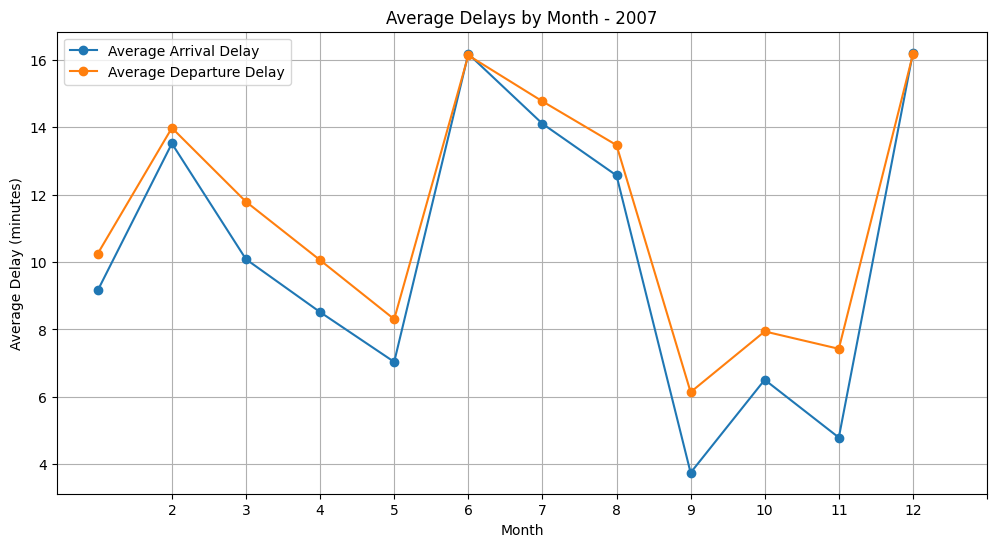


--- 2008 Seasonality Analysis ---
+-----+------------------+------------------+
|Month|       AvgArrDelay|       AvgDepDelay|
+-----+------------------+------------------+
|    1|10.188855960349496|11.437988179789825|
|    2|13.077836997760205|13.638067376696988|
|    3| 11.19236458018227|12.445089187974121|
|    4| 6.807297481094145| 8.167094182433619|
|    5| 5.978448290248828| 7.621401511990788|
|    6|13.266756009659792|13.567386784626288|
|    7| 9.975049681276131|11.781283767425007|
|    8|  6.91091468997087| 9.572297960882231|
|    9|0.6977328787273043| 3.949296215555673|
|   10|0.4154954706912698|3.7783654638624378|
|   11| 2.015857969430839| 5.387064576725042|
|   12|16.680505081496417|17.147783598572264|
+-----+------------------+------------------+



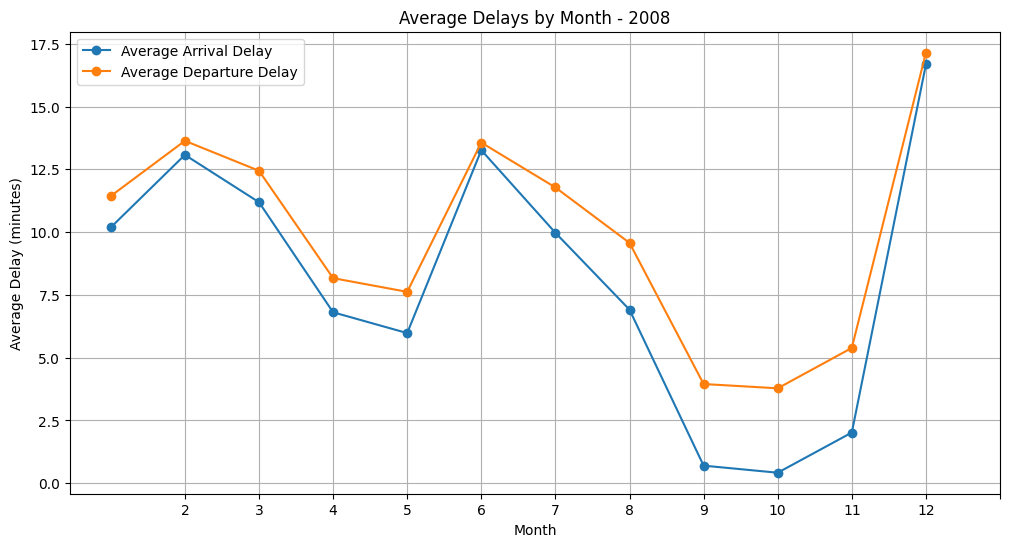

In [14]:
def seasonality_analysis(df, year):
    print(f"\n--- {year} Seasonality Analysis ---")

    df = df.filter((col("ArrDelay").isNotNull()) & (col("DepDelay").isNotNull()))

    monthly_delays = df.groupBy("Month") \
                       .agg(avg("ArrDelay").alias("AvgArrDelay"), avg("DepDelay").alias("AvgDepDelay")) \
                       .orderBy(col("Month").cast("int"))
    monthly_delays.show()

    monthly_delays_pandas = df.groupBy("Month") \
                       .agg(avg("ArrDelay").alias("AvgArrDelay"), avg("DepDelay").alias("AvgDepDelay")) \
                       .orderBy(col("Month").cast("int")).toPandas()

    plt.figure(figsize=(12, 6))
    plt.plot(monthly_delays_pandas["Month"], monthly_delays_pandas["AvgArrDelay"], label="Average Arrival Delay", marker='o')
    plt.plot(monthly_delays_pandas["Month"], monthly_delays_pandas["AvgDepDelay"], label="Average Departure Delay", marker='o')
    plt.xlabel("Month")
    plt.ylabel("Average Delay (minutes)")
    plt.title(f"Average Delays by Month - {year}")
    plt.xticks(range(1, 13))
    plt.legend()
    plt.grid(True)
    plt.show()

seasonality_analysis(df_2007, "2007")
seasonality_analysis(df_2008, "2008")

#4. Do you see any increase or decrease in delays on weekends?

No, there is no significant increase or decrease in delays between arrivals or departures on weekends

In [15]:
def weekend_effects(df, year):
    print(f"\n--- {year} Weekend Effects ---")

    df = df.filter((col("ArrDelay").isNotNull()) & (col("DepDelay").isNotNull()))

    weekend_delays = df.withColumn("Weekend", when(col("DayOfWeek").isin(1, 7), "Weekend").otherwise("Weekday"))
    weekend_avg_delays = weekend_delays.groupBy("Weekend").agg(avg("ArrDelay").alias("AvgArrDelay"), avg("DepDelay").alias("AvgDepDelay"))
    weekend_avg_delays.show()

weekend_effects(df_2007, "2007")
weekend_effects(df_2008, "2008")


--- 2007 Weekend Effects ---
+-------+------------------+------------------+
|Weekend|       AvgArrDelay|       AvgDepDelay|
+-------+------------------+------------------+
|Weekday|10.097547630274647|11.140469902787936|
|Weekend|10.424626426761403|11.906416423825455|
+-------+------------------+------------------+


--- 2008 Weekend Effects ---
+-------+-----------------+------------------+
|Weekend|      AvgArrDelay|       AvgDepDelay|
+-------+-----------------+------------------+
|Weekday|7.899869040825366| 9.548865907466434|
|Weekend|8.834680942779952|10.853991064905102|
+-------+-----------------+------------------+



#5. Are flights equally distributed throughout the day?

No. We can see that departures are concentrated between 6 AM - 10 PM and arrivals are concentrated between 7 AM - 12 AM for both 2007 and 2008 flights.



--- 2007 Time Distribution ---


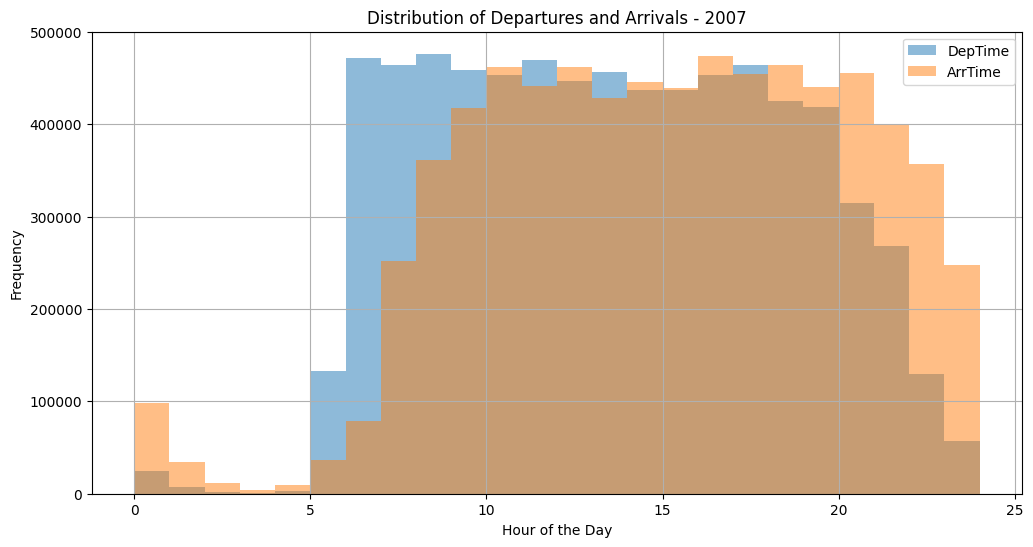


--- 2008 Time Distribution ---


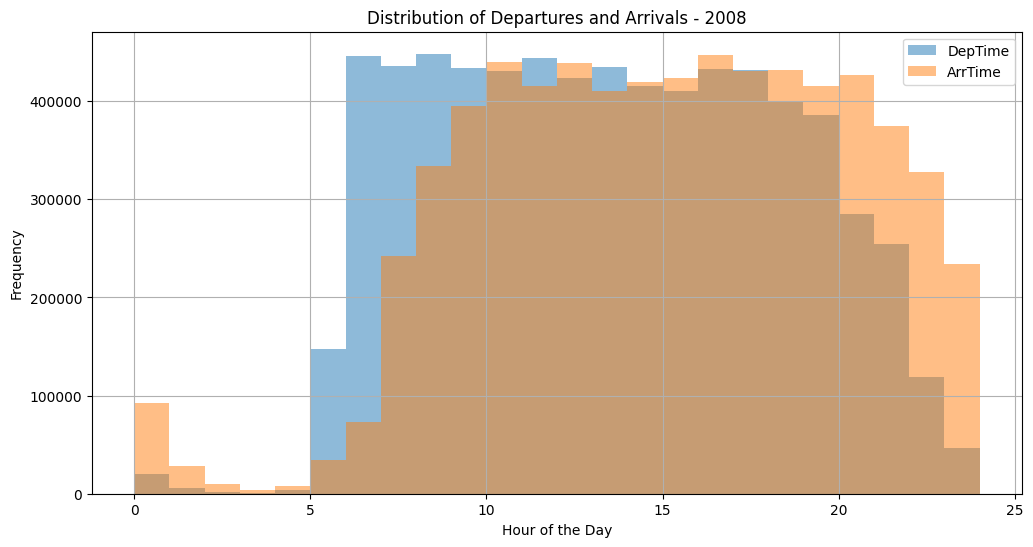

In [10]:
import matplotlib.pyplot as plt

def time_distribution(df, year):
    print(f"\n--- {year} Time Distribution ---")

    filtered_df = df.filter((col("DepTime").isNotNull()) & (col("ArrTime").isNotNull()) &
                            (col("DepTime") != "NA") & (col("ArrTime") != "NA"))

    df_pandas = filtered_df.select("DepTime", "ArrTime").toPandas()
    df_pandas["DepTime"] = pd.to_numeric(df_pandas["DepTime"], errors='coerce').dropna().astype(int)
    df_pandas["ArrTime"] = pd.to_numeric(df_pandas["ArrTime"], errors='coerce').dropna().astype(int)

    plt.figure(figsize=(12, 6))
    plt.hist(df_pandas["DepTime"] // 100, bins=24, alpha=0.5, label="DepTime")
    plt.hist(df_pandas["ArrTime"] // 100, bins=24, alpha=0.5, label="ArrTime")
    plt.xlabel("Hour of the Day")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Departures and Arrivals - {year}")
    plt.legend()
    plt.grid(True)
    plt.show()

time_distribution(df_2007, "2007")
time_distribution(df_2008, "2008")

#6. Do you see the worst delays at any certain times of the day?

We can see that the worst delays happen at night between the hours of 10 PM to 4AM.


I. The comparision of CSR Time and Actual time or Arrivals and Departures


--- 2007 Comparison of Scheduled vs Actual Times ---


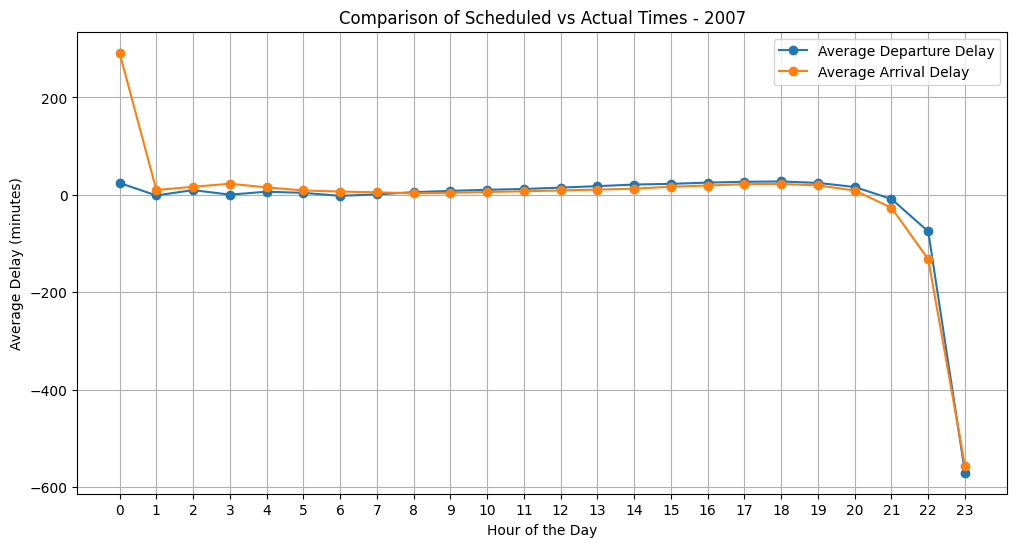


--- 2008 Comparison of Scheduled vs Actual Times ---


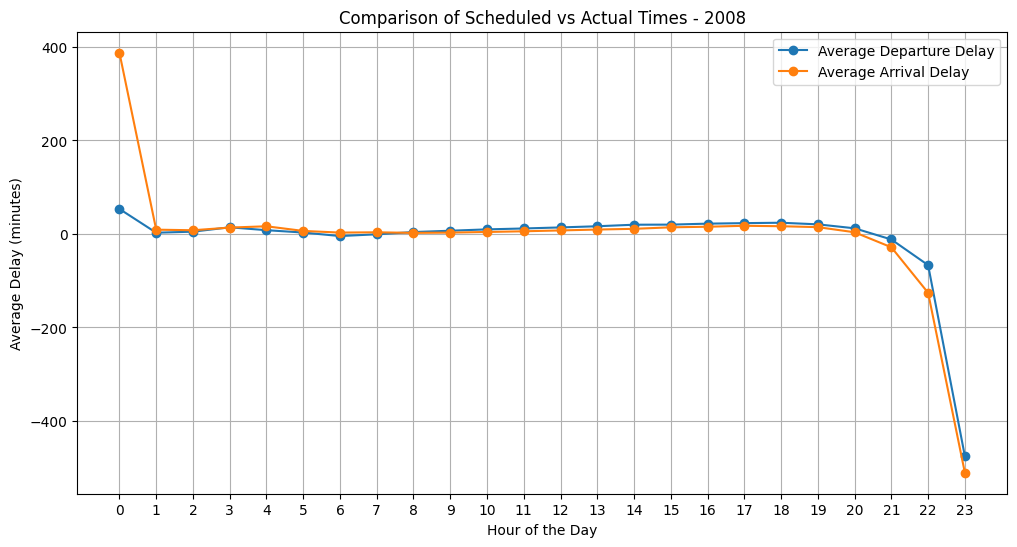

In [12]:
def compare_scheduled_vs_actual(df, year):
    print(f"\n--- {year} Comparison of Scheduled vs Actual Times ---")

    filtered_df = df.filter((col("DepTime").isNotNull()) & (col("ArrTime").isNotNull()) &
                            (col("CRSDepTime").isNotNull()) & (col("CRSArrTime").isNotNull()) &
                            (col("DepTime") != "NA") & (col("ArrTime") != "NA") &
                            (col("CRSDepTime") != "NA") & (col("CRSArrTime") != "NA"))

    time_delays = filtered_df.withColumn("DepHour", (col("CRSDepTime") / 100).cast("int")) \
                             .withColumn("ArrHour", (col("CRSArrTime") / 100).cast("int")) \
                             .withColumn("DepDelay", (col("DepTime") - col("CRSDepTime"))) \
                             .withColumn("ArrDelay", (col("ArrTime") - col("CRSArrTime")))

    dep_delay_by_hour = time_delays.groupBy("DepHour") \
                                   .agg(avg("DepDelay").alias("AvgDepDelay")) \
                                   .orderBy("DepHour") \
                                   .toPandas()

    arr_delay_by_hour = time_delays.groupBy("ArrHour") \
                                   .agg(avg("ArrDelay").alias("AvgArrDelay")) \
                                   .orderBy("ArrHour") \
                                   .toPandas()

    plt.figure(figsize=(12, 6))
    plt.plot(dep_delay_by_hour["DepHour"], dep_delay_by_hour["AvgDepDelay"], label="Average Departure Delay", marker='o')
    plt.plot(arr_delay_by_hour["ArrHour"], arr_delay_by_hour["AvgArrDelay"], label="Average Arrival Delay", marker='o')
    plt.xlabel("Hour of the Day")
    plt.ylabel("Average Delay (minutes)")
    plt.title(f"Comparison of Scheduled vs Actual Times - {year}")
    plt.xticks(range(24))
    plt.legend()
    plt.grid(True)
    plt.show()

compare_scheduled_vs_actual(df_2007, "2007")
compare_scheduled_vs_actual(df_2008, "2008")

II. The comparision of Departure/Arrival time and Arrival/Departure Delay


--- 2007 Average Delays by Time of Day ---


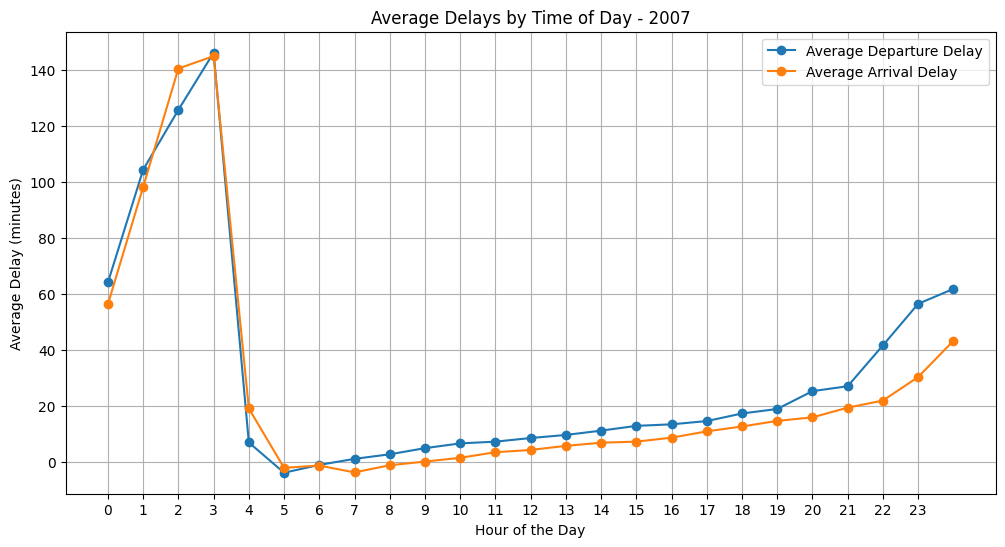


--- 2008 Average Delays by Time of Day ---


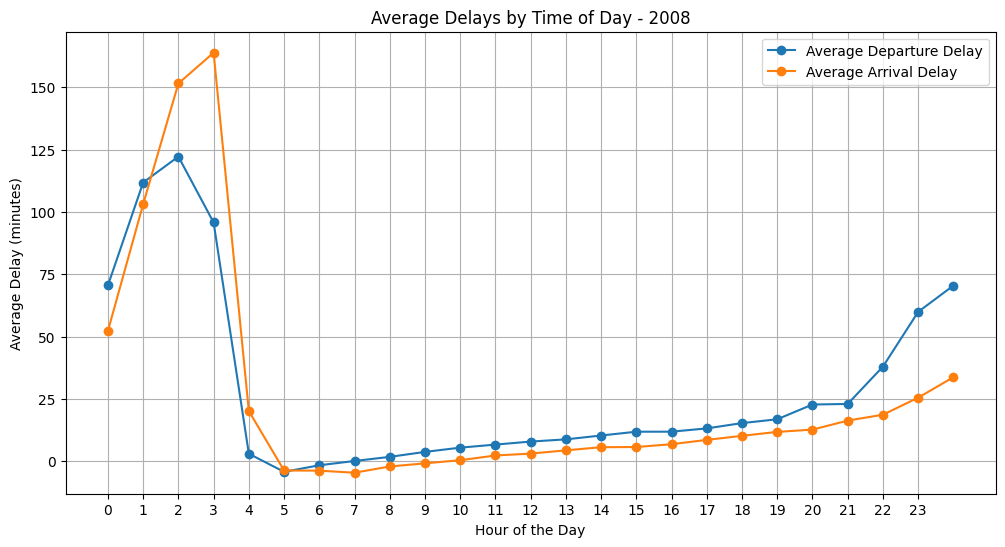

In [17]:
def delay_by_time_of_day(df, year):
    print(f"\n--- {year} Average Delays by Time of Day ---")

    df = df.filter((col("ArrDelay").isNotNull()) & (col("DepDelay").isNotNull()))


    time_delays = df.withColumn("DepHour", (col("DepTime") / 100).cast("int")) \
                    .withColumn("ArrHour", (col("ArrTime") / 100).cast("int"))

    dep_delay_by_hour = time_delays.groupBy("DepHour") \
                                   .agg(avg("DepDelay").alias("AvgDepDelay")) \
                                   .orderBy("DepHour") \
                                   .toPandas()

    arr_delay_by_hour = time_delays.groupBy("ArrHour") \
                                   .agg(avg("ArrDelay").alias("AvgArrDelay")) \
                                   .orderBy("ArrHour") \
                                   .toPandas()

    plt.figure(figsize=(12, 6))
    plt.plot(dep_delay_by_hour["DepHour"], dep_delay_by_hour["AvgDepDelay"], label="Average Departure Delay", marker='o')
    plt.plot(arr_delay_by_hour["ArrHour"], arr_delay_by_hour["AvgArrDelay"], label="Average Arrival Delay", marker='o')
    plt.xlabel("Hour of the Day")
    plt.ylabel("Average Delay (minutes)")
    plt.title(f"Average Delays by Time of Day - {year}")
    plt.xticks(range(24))
    plt.legend()
    plt.grid(True)
    plt.show()

delay_by_time_of_day(df_2007, "2007")
delay_by_time_of_day(df_2008, "2008")